# Hovercraft model

In [1]:
# Install Ipopt
using Pkg
Pkg.add("Ipopt")
Pkg.add("PyPlot")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [2]:
using JuMP, Ipopt

    k = 4              # number of waypoints
    T = zeros(Int,k)   # vector of timepoints
    xw = zeros(2,k)    # vector of waypoint locations

    T[1] = 1
    T[2] = 20
    T[3] = 35
    T[4] = 60

    # define waypoints
    xw = [ 1   4   7   1
           1   3   0   1 ]

# Function to generate model, solve optimization problem 
# and return solution for a given λ
function solveOpt(λ)
    # m = Model(solver = GurobiSolver(OutputFlag=0))
    m = Model(Ipopt.Optimizer)
    
    @variable(m, x[1:2,1:T[k]])  # resulting position
    @variable(m, v[1:2,1:T[k]])  # resulting velocity
    @variable(m, u[1:2,1:T[k]])  # thruster input

    # zero initial velocity
    @constraint(m, v[:,1] .== [0;0])
    
    # satisfy the dynamics 
    for t in 1:T[k]-1
        @constraint(m, x[:,t+1] .== x[:,t] + v[:,t])
        @constraint(m, v[:,t+1] .== v[:,t] + u[:,t])
    end
    # make the solution periodic!
    #@constraint(m, x[:,1] .== x[:,T[k]])
    #@constraint(m, v[:,1] .== v[:,T[k]])

    
#     # hit all the waypoints
#     for i in 1:k
#         @constraint(m, x[:,T[i]] .== xw[:,i])
#     end
    
    
    # hit the first waypoint only
    for i in [1 k]
        @constraint(m, x[:,T[i]] .== xw[:,i])
    end
    
    
    # minimize 2-norm (SIMILAR TO LEAST-SQUARES!)
    @objective(m, Min, sum(u.^2) + λ*sum( (x[:,T]-xw).^2 ) )
    
    optimize!(m)
    
    J1 = JuMP.value.(sum(u.^2))
    J2 = JuMP.value.(sum( (x[:,T]-xw).^2  ))
    xopt = JuMP.value.(x)
    
    return (J1,J2,xopt)
end
;

## Plot trajectory


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      714
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      128

Total number of variables............................:      360
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      242
Total number of inequality c

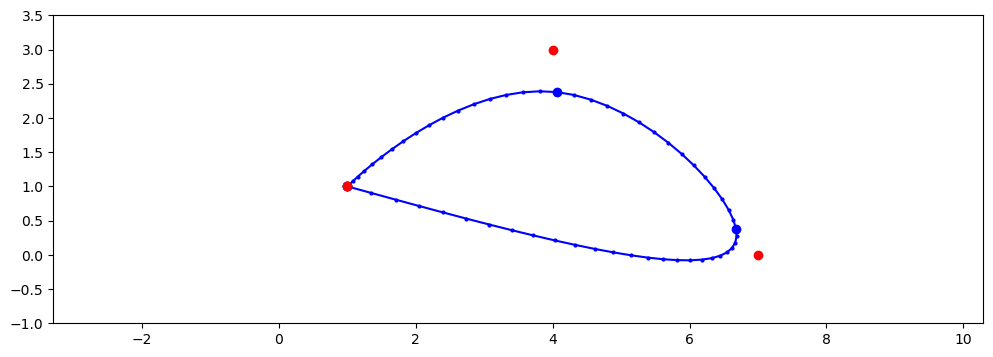

In [3]:
λ = 0.01
(J1x,J2x,x) = solveOpt(λ)

using PyPlot
figure(figsize=(12,4))
plot( x[1,:], x[2,:], "b.-", markersize=4 )
plot( x[1,T], x[2,T], "b.", markersize=12 )
plot( xw[1,:], xw[2,:], "r.", markersize=12 )
axis("equal")
axis((1.,6.,-1,3.5));

## Compute tradeoff curve

In [4]:
Npts = 30
J1 = zeros(Npts)
J2 = zeros(Npts)
for (i,λ) in enumerate(10.0.^range(-5,1,length=Npts))
    (J1[i],J2[i],uu) = solveOpt(λ)
end;

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      714
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      128

Total number of variables............................:      360
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      242
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.8000000e-04 1.00e+00 4.38e-05  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

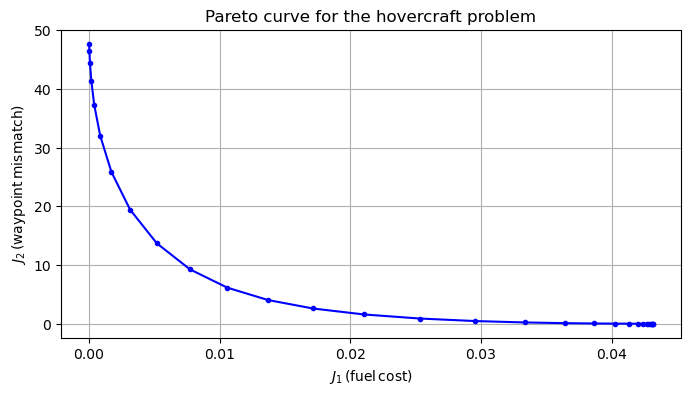

In [5]:
using PyPlot
figure(figsize=(8,4))
plot( J1, J2, "b.-" )
xlabel(L"J_1\, (\sf fuel\, cost)")
ylabel(L"J_2\, (\sf waypoint\, mismatch)");
title("Pareto curve for the hovercraft problem")
grid()